 
# CTSLEB

In this notebook, we will use CTSLEB to calculate the Polygenic Risk Score (PRS).

## Installation

To install CTSLEB, open R using the command prompt or terminal and enter the following commands:

```R
install.packages("devtools")
library(devtools)
install_github("andrewhaoyu/CTSLEB")
```
 

Download the tutorial HTML file from the author to follow along:

[CTSLEB Tutorial](https://github.com/andrewhaoyu/CTSLEB/blob/main/Tutorial_CTSLEB.html)
[CTSLEB Tutorial](https://github.com/andrewhaoyu/CTSLEB/blob/main/Tutorial_CTSLEB.Rmd)

### Overview of the Tool

This tool uses two GWAS datasets (same phenotype but different populations) to estimate risk scores for the target population.

1. **Target GWAS**: We considered the target GWAS to be for a specific phenotype.
2. **Original GWAS**: We used a GWAS for the asthma phenotype to illustrate the process. According to the tool documentation, the population should be different, but the disease should be the same. This approach was taken to demonstrate usage.
3. **Different Populations Requirement**: Both GWAS datasets should be from different populations; otherwise, the code may not work.
4. **Train and Test Sets**: Different train and test sets can be used, though we opted to use the same set for both, as multiple GWAS datasets can share genotype data.
 


```python
        'Rscript CTSLEB.R',                       # R script
         filedirec,                         # Argument one: directory for gwas1
         filedirec,                         # Argument two: directory for gwas2
         filedirec + os.sep +filedirec+"ORGINAL_CTSLEB.txt", # Argument three: file name for RANDOM LARGE EUR data
         filedirec + os.sep +filedirec+"TARGET_CTSLEB.txt", # Argument four: file name for TARGET data
         "./plink",                     # Argument five: Plink path
         "./plink2",                      # Argument six: Plink2 path
         traindirec+os.sep+newtrainfilename +".clumped.pruned",                  # Argument seven: train genotype data for population 1
         traindirec+os.sep+newtrainfilename +".clumped.pruned",                  # Argument eight: train genotype data for population 2
         traindirec+os.sep+newtrainfilename +".clumped.pruned",                    # Argument nine: test genotype data for population 1
         traindirec+os.sep+newtrainfilename +".clumped.pruned",                # Argument ten: test genotype data for population 2
         traindirec+os.sep+Name+os.sep,                    # Argument eleven: outdirectory
         "CTSLEB",                       # Argument twelve: outprefix
        traindirec+os.sep+Name+os.sep+"tunning_train.txt", #train Phenotype
        traindirec+os.sep+Name+os.sep+"tunning_test.txt", #test Phenotype

```



## Plink Hyperparameters

[Plink](https://zzz.bwh.harvard.edu/plink/clump.shtml) is a tool that allows us to perform clumping and pruning. It also lets us specify the p-value thresholds used on the training data. For each combination of clumping, pruning, and p-value thresholds, a polygenic risk code is generated for each person. Plink takes beta coefficients or OR ratios from the GWAS file without re-estimating those values. Clumping and pruning are performed on the training data using the specified p-value thresholds. The same remaining number of SNPs from the test set is then used to estimate the polygenic risk scores. No separate clumping and pruning are required on the test set.

Details about clumping can be found [here](https://zzz.bwh.harvard.edu/plink/clump.shtml), and information about pruning is available [here](https://www.cog-genomics.org/plink/1.9/ld). P-value threshold documentation can be found [here](https://www.cog-genomics.org/plink/2.0/score#:~:text=%2D%2Dq%2Dscore%2Drange%20can,in%20the%20third%20column%2C%20e.g., for the scorecard.


### Pruning Parameters

Informs Plink that we wish to perform pruning with a window size of 200 variants, sliding across the genome with a step size of 50 variants at a time, and filter out any SNPs with LD \( r^2 \) higher than 0.25.

```python
1. p_window_size = [200]
2. p_slide_size = [50]
3. p_LD_threshold = [0.25]
```

### Clumping Parameters

The P-value threshold for an SNP to be included. 1 means to include all SNPs for clumping. SNPs having \( r^2 \) higher than 0.1 with the index SNPs will be removed. SNPs within 200k of the index SNP are considered for clumping.

```python
1. clump_p1 = [1]
2. clump_r2 = [0.1]
3. clump_kb = [200]
```

### Score Parameters
--q-score-range can be used to apply --score too many variants subsets at once, based on, e.g., p-value ranges.

The "range file" should have range labels in the first column, p-value lower bounds in the second column, and upper bounds in the third column, e.g.
```python
1. pv_1  0.00 0.01
2. pv_2  0.00 0.20
```

### PCA
Pca also affects the results evident from the initial analysis; however, including more PCA overfits the model. 




**Kindly note that the number of p-values to be considered varies, and the actual p-value also depends on the dataset. Moreover, after clumping, pruning, and p-value threshold, the number of SNPs in each fold can vary.**

 

In [2]:
!pip install statsmodels
!pip install scikit-learn

## Generate Target GWAS

The gwas file for the two populations should be different. We used phenotype gwas and genotype data as the target, and the sample data as base gwas and the genotype data of the target population.



In [3]:
import os
import pandas as pd
import numpy as np
import sys


#filedirec = sys.argv[1]

filedirec = "SampleData1"
#filedirec = "asthma_19"
#filedirec = "migraine_0"

def check_phenotype_is_binary_or_continous(filedirec):
    # Read the processed quality controlled file for a phenotype
    df = pd.read_csv(filedirec+os.sep+filedirec+'_QC.fam',sep="\s+",header=None)
    column_values = df[5].unique()
 
    if len(set(column_values)) == 2:
        return "Binary"
    else:
        return "Continous"



# Read the GWAS file.
GWAS = filedirec + os.sep + filedirec+".gz"
df = pd.read_csv(GWAS,compression= "gzip",sep="\s+")


if "BETA" in df.columns.to_list():
    # For Continous Phenotype.
    df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'BETA', 'INFO', 'MAF']]

else:
    df["BETA"] = np.log(df["OR"])
    df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'BETA', 'INFO', 'MAF']]

 
transformed_df = pd.DataFrame({
    'CHR': df['CHR'].astype(int),
     #'SNP': df['SNP'].astype(str) + ":" + df['BP'].astype(str) + ":" + df['A1'] + ":" + df['A2'],
     'SNP': df['SNP'].astype(str),
    
    'BP': df['BP'].astype(int),
    'A1': df['A1'],
    'BETA': df['BETA'].astype(float),
    'SE': df['SE'].astype(float),
    'P': df['P'].astype(float)
})

# Example of rs_id extraction (using a subset of original SNP names)
transformed_df['rs_id'] = df['SNP']
  
##      CHR                      SNP       BP     A1      BETA          SE      P
##    <int>                   <char>    <int> <char>     <num>       <num>  <num>
## 1:    22  rs55926024:16054740:A:G 16054740      G  0.003215 0.004537115 0.4786
## 2:    22   rs4389403:16055070:G:A 16055070      A  0.006085 0.006921065 0.3793
## 3:    22 rs117246541:16055122:G:T 16055122      T  0.009954 0.008392917 0.2356
## 4:    22  rs72613661:16055942:C:T 16055942      C -0.002443 0.005135590 0.6343
## 5:    22   rs9617528:16061016:T:C 16061016      C -0.002830 0.005117541 0.5803
## 6:    22 rs140813654:16070003:C:T 16070003      T -0.003224 0.005580751 0.5635
##          rs_id
##         <char>
## 1:   rs2844885
## 2:   rs4389403
## 3: rs117246541
## 4:    rs738830
## 5:   rs9617528
## 6:  rs62224655

transformed_df.to_csv(filedirec + os.sep +filedirec+"TARGET_CTSLEB.txt",sep="\t",index=False)
#transformed_df.to_csv(filedirec + os.sep +filedirec+"_CTSLEB2.txt",sep="\t",index=False)

print(transformed_df.head().to_markdown())
print("Length of DataFrame!",len(transformed_df))


|    |   CHR | SNP        |     BP | A1   |        BETA |         SE |        P | rs_id      |
|---:|------:|:-----------|-------:|:-----|------------:|-----------:|---------:|:-----------|
|  0 |     1 | rs3131962  | 756604 | A    | -0.00211532 | 0.00301666 | 0.483171 | rs3131962  |
|  1 |     1 | rs12562034 | 768448 | A    |  0.00068708 | 0.00329472 | 0.834808 | rs12562034 |
|  2 |     1 | rs4040617  | 779322 | G    | -0.00239932 | 0.00303344 | 0.42897  | rs4040617  |
|  3 |     1 | rs79373928 | 801536 | G    |  0.00203363 | 0.00841324 | 0.808999 | rs79373928 |
|  4 |     1 | rs11240779 | 808631 | G    |  0.00130747 | 0.00242821 | 0.590265 | rs11240779 |
Length of DataFrame! 499617


## Generate Orginal GWAS
We considered download asthma gwas from the gwas cataglo, and named it CTSLEB.gwas, and stored it as ORGINAL gwas or the base GWWAS.

In [4]:
import os
import pandas as pd
import numpy as np

 

def check_phenotype_is_binary_or_continous(filedirec):
    # Read the processed quality controlled file for a phenotype
    df = pd.read_csv(filedirec+os.sep+filedirec+'_QC.fam',sep="\s+",header=None)
    column_values = df[5].unique()
 
    if len(set(column_values)) == 2:
        return "Binary"
    else:
        return "Continous"


 
df = pd.read_csv("CTSLEB.gwas" ,sep="\s+")


if "BETA" in df.columns.to_list():
    # For Continous Phenotype.
    df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'BETA', 'INFO', 'MAF']]

else:
    df["BETA"] = np.log(df["OR"])
    df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'BETA', 'INFO', 'MAF']]

 
transformed_df = pd.DataFrame({
    'CHR': df['CHR'].astype(int),
     #'SNP': df['SNP'].astype(str) + ":" + df['BP'].astype(str) + ":" + df['A1'] + ":" + df['A2'],
     'SNP': df['SNP'].astype(str),
    
    'BP': df['BP'].astype(int),
    'A1': df['A1'],
    'BETA': df['BETA'].astype(float),
    'SE': df['SE'].astype(float),
    'P': df['P'].astype(float)
})

# Example of rs_id extraction (using a subset of original SNP names)
transformed_df['rs_id'] = df['SNP']
  
##      CHR                      SNP       BP     A1      BETA          SE      P
##    <int>                   <char>    <int> <char>     <num>       <num>  <num>
## 1:    22  rs55926024:16054740:A:G 16054740      G  0.003215 0.004537115 0.4786
## 2:    22   rs4389403:16055070:G:A 16055070      A  0.006085 0.006921065 0.3793
## 3:    22 rs117246541:16055122:G:T 16055122      T  0.009954 0.008392917 0.2356
## 4:    22  rs72613661:16055942:C:T 16055942      C -0.002443 0.005135590 0.6343
## 5:    22   rs9617528:16061016:T:C 16061016      C -0.002830 0.005117541 0.5803
## 6:    22 rs140813654:16070003:C:T 16070003      T -0.003224 0.005580751 0.5635
##          rs_id
##         <char>
## 1:   rs2844885
## 2:   rs4389403
## 3: rs117246541
## 4:    rs738830
## 5:   rs9617528
## 6:  rs62224655

transformed_df.to_csv(filedirec + os.sep +filedirec+"ORGINAL_CTSLEB.txt",sep="\t",index=False)
#transformed_df.to_csv(filedirec + os.sep +filedirec+"_CTSLEB2.txt",sep="\t",index=False)

print(transformed_df.head().to_markdown())
print("Length of DataFrame!",len(transformed_df))


|    |   CHR | SNP       |      BP | A1   |       BETA |        SE |        P | rs_id     |
|---:|------:|:----------|--------:|:-----|-----------:|----------:|---------:|:----------|
|  0 |     1 | rs3094315 |  752566 | A    | -0.0152675 | 0.0237699 | 0.520677 | rs3094315 |
|  1 |     1 | rs4040617 |  779322 | G    |  0.0111747 | 0.0303204 | 0.71246  | rs4040617 |
|  2 |     1 | rs2905062 |  785050 | A    | -0.0137348 | 0.031774  | 0.665548 | rs2905062 |
|  3 |     1 | rs2980300 |  785989 | C    | -0.0148826 | 0.0317324 | 0.639067 | rs2980300 |
|  4 |     1 | rs4075116 | 1003629 | T    |  0.0140401 | 0.0166918 | 0.400269 | rs4075116 |
Length of DataFrame! 2001280


### Define Hyperparameters

Define hyperparameters to be optimized and set initial values.

### Extract Valid SNPs from Clumped File

For Windows, download `gwak`, and for Linux, the `awk` command is sufficient. For Windows, `GWAK` is required. You can download it from [here](https://sourceforge.net/projects/gnuwin32/). Get it and place it in the same directory.


### Execution Path

At this stage, we have the genotype training data `newtrainfilename = "train_data.QC"` and genotype test data `newtestfilename = "test_data.QC"`.

We modified the following variables:

1. `filedirec = "SampleData1"` or `filedirec = sys.argv[1]`
2. `foldnumber = "0"` or `foldnumber = sys.argv[2]` for HPC.

Only these two variables can be modified to execute the code for specific data and specific folds. Though the code can be executed separately for each fold on HPC and separately for each dataset, it is recommended to execute it for multiple diseases and one fold at a time.
Here’s the corrected text in Markdown format:

 
### P-values

PRS calculation relies on P-values. SNPs with low P-values, indicating a high degree of association with a specific trait, are considered for calculation.

You can modify the code below to consider a specific set of P-values and save the file in the same format.

We considered the following parameters:

- **Minimum P-value**: `1e-10`
- **Maximum P-value**: `1.0`
- **Minimum exponent**: `10`  (Minimum P-value in exponent)
- **Number of intervals**: `100`  (Number of intervals to be considered)

The code generates an array of logarithmically spaced P-values:

```python
import numpy as np
import os

minimumpvalue = 10  # Minimum exponent for P-values
numberofintervals = 100  # Number of intervals to be considered

allpvalues = np.logspace(-minimumpvalue, 0, numberofintervals, endpoint=True)  # Generating an array of logarithmically spaced P-values

print("Minimum P-value:", allpvalues[0])
print("Maximum P-value:", allpvalues[-1])

count = 1
with open(os.path.join(folddirec, 'range_list'), 'w') as file:
    for value in allpvalues:
        file.write(f'pv_{value} 0 {value}\n')  # Writing range information to the 'range_list' file
        count += 1

pvaluefile = os.path.join(folddirec, 'range_list')
```

In this code:
- `minimumpvalue` defines the minimum exponent for P-values.
- `numberofintervals` specifies how many intervals to consider.
- `allpvalues` generates an array of P-values spaced logarithmically.
- The script writes these P-values to a file named `range_list` in the specified directory.
 

In [5]:
from operator import index
import pandas as pd
import numpy as np
import os
import subprocess
import sys
import pandas as pd
import statsmodels.api as sm
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix
from statsmodels.stats.contingency_tables import mcnemar

def create_directory(directory):
    """Function to create a directory if it doesn't exist."""
    if not os.path.exists(directory):  # Checking if the directory doesn't exist
        os.makedirs(directory)  # Creating the directory if it doesn't exist
    return directory  # Returning the created or existing directory

 
#foldnumber = sys.argv[1]
foldnumber = "0"  # Setting 'foldnumber' to "0"

folddirec = filedirec + os.sep + "Fold_" + foldnumber  # Creating a directory path for the specific fold
trainfilename = "train_data"  # Setting the name of the training data file
newtrainfilename = "train_data.QC"  # Setting the name of the new training data file

testfilename = "test_data"  # Setting the name of the test data file
newtestfilename = "test_data.QC"  # Setting the name of the new test data file

# Number of PCA to be included as a covariate.
numberofpca = ["6"]  # Setting the number of PCA components to be included

# Clumping parameters.
clump_p1 = [1]  # List containing clump parameter 'p1'
clump_r2 = [0.1]  # List containing clump parameter 'r2'
clump_kb = [200]  # List containing clump parameter 'kb'

# Pruning parameters.
p_window_size = [200]  # List containing pruning parameter 'window_size'
p_slide_size = [50]  # List containing pruning parameter 'slide_size'
p_LD_threshold = [0.25]  # List containing pruning parameter 'LD_threshold'

# Kindly note that the number of p-values to be considered varies, and the actual p-value depends on the dataset as well.
# We will specify the range list here.

minimumpvalue = 10  # Minimum p-value in exponent
numberofintervals = 20  # Number of intervals to be considered
allpvalues = np.logspace(-minimumpvalue, 0, numberofintervals, endpoint=True)  # Generating an array of logarithmically spaced p-values



count = 1
with open(folddirec + os.sep + 'range_list', 'w') as file:
    for value in allpvalues:
        file.write(f'pv_{value} 0 {value}\n')  # Writing range information to the 'range_list' file
        count = count + 1

pvaluefile = folddirec + os.sep + 'range_list'

# Initializing an empty DataFrame with specified column names
prs_result = pd.DataFrame(columns=["clump_p1", "clump_r2", "clump_kb", "p_window_size", "p_slide_size", "p_LD_threshold",
                                   "pvalue", "numberofpca","numberofvariants","Train_pure_prs", "Train_null_model", "Train_best_model",
                                   "Test_pure_prs", "Test_null_model", "Test_best_model"])

### Define Helper Functions

1. **Perform Clumping and Pruning**
2. **Calculate PCA Using Plink**
3. **Fit Binary Phenotype and Save Results**
4. **Fit Continuous Phenotype and Save Results**


In [8]:
import os
import subprocess
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import explained_variance_score


def perform_clumping_and_pruning_on_individual_data(traindirec, newtrainfilename,numberofpca, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile):
    
    command = [
    "./plink",
    "--bfile", traindirec+os.sep+newtrainfilename,
    "--indep-pairwise", p1_val, p2_val, p3_val,
    "--out", traindirec+os.sep+trainfilename
    ]
    subprocess.run(command)
    # First perform pruning and then clumping and the pruning.

    command = [
    "./plink",
    "--bfile", traindirec+os.sep+newtrainfilename,
    "--clump-p1", c1_val,
    "--extract", traindirec+os.sep+trainfilename+".prune.in",
    "--clump-r2", c2_val,
    "--clump-kb", c3_val,
    "--clump", filedirec+os.sep+filedirec+".txt",
    "--clump-snp-field", "SNP",
    "--clump-field", "P",
    "--out", traindirec+os.sep+trainfilename
    ]    
    subprocess.run(command)

    # Extract the valid SNPs from th clumped file.
    # For windows download gwak for linux awk commmand is sufficient.
    ### For windows require GWAK.
    ### https://sourceforge.net/projects/gnuwin32/
    ##3 Get it and place it in the same direc.
    #os.system("gawk "+"\""+"NR!=1{print $3}"+"\"  "+ traindirec+os.sep+trainfilename+".clumped >  "+traindirec+os.sep+trainfilename+".valid.snp")
    #print("gawk "+"\""+"NR!=1{print $3}"+"\"  "+ traindirec+os.sep+trainfilename+".clumped >  "+traindirec+os.sep+trainfilename+".valid.snp")

    #Linux:
    command = f"awk 'NR!=1{{print $3}}' {traindirec}{os.sep}{trainfilename}.clumped > {traindirec}{os.sep}{trainfilename}.valid.snp"
    os.system(command)
    
    command = [
    "./plink",
    "--make-bed",
    "--bfile", traindirec+os.sep+newtrainfilename,
    "--indep-pairwise", p1_val, p2_val, p3_val,
    "--extract", traindirec+os.sep+trainfilename+".valid.snp",
    "--out", traindirec+os.sep+newtrainfilename+".clumped.pruned"
    ]
    subprocess.run(command)
    
    command = [
    "./plink",
    "--make-bed",
    "--bfile", traindirec+os.sep+testfilename,
    "--indep-pairwise", p1_val, p2_val, p3_val,
    "--extract", traindirec+os.sep+trainfilename+".valid.snp",
    "--out", traindirec+os.sep+testfilename+".clumped.pruned"
    ]
    subprocess.run(command)    
    
    
 
def calculate_pca_for_traindata_testdata_for_clumped_pruned_snps(traindirec, newtrainfilename,p):
    
    # Calculate the PRS for the test data using the same set of SNPs and also calculate the PCA.


    # Also extract the PCA at this point.
    # PCA are calculated afer clumping and pruining.
    command = [
        "./plink",
        "--bfile", folddirec+os.sep+testfilename+".clumped.pruned",
        # Select the final variants after clumping and pruning.
        "--extract", traindirec+os.sep+trainfilename+".valid.snp",
        "--pca", p,
        "--out", folddirec+os.sep+testfilename
    ]
    subprocess.run(command)


    command = [
    "./plink",
        "--bfile", traindirec+os.sep+newtrainfilename+".clumped.pruned",
        # Select the final variants after clumping and pruning.        
        "--extract", traindirec+os.sep+trainfilename+".valid.snp",
        "--pca", p,
        "--out", traindirec+os.sep+trainfilename
    ]
    subprocess.run(command)

# This function fit the binary model on the PRS.
def fit_binary_phenotype_on_PRS(traindirec, newtrainfilename,p, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile):
    threshold_values = allpvalues

    # Merge the covariates, pca and phenotypes.
    tempphenotype_train = pd.read_table(traindirec+os.sep+newtrainfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_train = pd.DataFrame()
    phenotype_train["Phenotype"] = tempphenotype_train[5].values
    pcs_train = pd.read_table(traindirec+os.sep+trainfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_train = pd.read_table(traindirec+os.sep+trainfilename+".cov",sep="\s+")
    covariate_train.fillna(0, inplace=True)
    covariate_train = covariate_train[covariate_train["FID"].isin(pcs_train["FID"].values) & covariate_train["IID"].isin(pcs_train["IID"].values)]
    covariate_train['FID'] = covariate_train['FID'].astype(str)
    pcs_train['FID'] = pcs_train['FID'].astype(str)
    covariate_train['IID'] = covariate_train['IID'].astype(str)
    pcs_train['IID'] = pcs_train['IID'].astype(str)
    covandpcs_train = pd.merge(covariate_train, pcs_train, on=["FID","IID"])
    covandpcs_train.fillna(0, inplace=True)


    ## Scale the covariates!
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import explained_variance_score
    scaler = MinMaxScaler()
    normalized_values_train = scaler.fit_transform(covandpcs_train.iloc[:, 2:])
    #covandpcs_train.iloc[:, 2:] = normalized_values_test 
    
    
    tempphenotype_test = pd.read_table(traindirec+os.sep+testfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_test= pd.DataFrame()
    phenotype_test["Phenotype"] = tempphenotype_test[5].values
    pcs_test = pd.read_table(traindirec+os.sep+testfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_test = pd.read_table(traindirec+os.sep+testfilename+".cov",sep="\s+")
    covariate_test.fillna(0, inplace=True)
    covariate_test = covariate_test[covariate_test["FID"].isin(pcs_test["FID"].values) & covariate_test["IID"].isin(pcs_test["IID"].values)]
    covariate_test['FID'] = covariate_test['FID'].astype(str)
    pcs_test['FID'] = pcs_test['FID'].astype(str)
    covariate_test['IID'] = covariate_test['IID'].astype(str)
    pcs_test['IID'] = pcs_test['IID'].astype(str)
    covandpcs_test = pd.merge(covariate_test, pcs_test, on=["FID","IID"])
    covandpcs_test.fillna(0, inplace=True)
    normalized_values_test  = scaler.transform(covandpcs_test.iloc[:, 2:])
    #covandpcs_test.iloc[:, 2:] = normalized_values_test     
    
    
    
    
    tempalphas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    l1weights = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

    tempalphas = [0.1]
    l1weights = [0.1]

    phenotype_train["Phenotype"] = phenotype_train["Phenotype"].replace({1: 0, 2: 1}) 
    phenotype_test["Phenotype"] = phenotype_test["Phenotype"].replace({1: 0, 2: 1})
      
    for tempalpha in tempalphas:
        for l1weight in l1weights:

            
            try:
                null_model =  sm.Logit(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                #null_model =  sm.Logit(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit()
            
            except:
                print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
                continue

            train_null_predicted = null_model.predict(sm.add_constant(covandpcs_train.iloc[:, 2:]))
            
            from sklearn.metrics import roc_auc_score, confusion_matrix
            from sklearn.metrics import r2_score
            
            test_null_predicted = null_model.predict(sm.add_constant(covandpcs_test.iloc[:, 2:]))
            
           
            
            global prs_result 
            for i in threshold_values:
                try:
                    prs_train = pd.read_table(traindirec+os.sep+Name+os.sep+"train_data.pv_"+f"{i}.profile", sep="\s+", usecols=["FID", "IID", "SCORE"])
                except:
                    continue

                prs_train['FID'] = prs_train['FID'].astype(str)
                prs_train['IID'] = prs_train['IID'].astype(str)
                try:
                    prs_test = pd.read_table(traindirec+os.sep+Name+os.sep+"test_data.pv_"+f"{i}.profile", sep="\s+", usecols=["FID", "IID", "SCORE"])
                except:
                    continue
                prs_test['FID'] = prs_test['FID'].astype(str)
                prs_test['IID'] = prs_test['IID'].astype(str)
                pheno_prs_train = pd.merge(covandpcs_train, prs_train, on=["FID", "IID"])
                pheno_prs_test = pd.merge(covandpcs_test, prs_test, on=["FID", "IID"])
        
                try:
                    model = sm.Logit(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                    #model = sm.Logit(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit()
                
                except:
                    continue


                
                train_best_predicted = model.predict(sm.add_constant(pheno_prs_train.iloc[:, 2:]))    
 

                test_best_predicted = model.predict(sm.add_constant(pheno_prs_test.iloc[:, 2:])) 
 
        
                from sklearn.metrics import roc_auc_score, confusion_matrix

                prs_result = prs_result._append({
                    "clump_p1": c1_val,
                    "clump_r2": c2_val,
                    "clump_kb": c3_val,
                    "p_window_size": p1_val,
                    "p_slide_size": p2_val,
                    "p_LD_threshold": p3_val,
                    "pvalue": i,
                    "numberofpca":p, 

                    "tempalpha":str(tempalpha),
                    "l1weight":str(l1weight),
                      

                    "Train_pure_prs":roc_auc_score(phenotype_train["Phenotype"].values,prs_train['SCORE'].values),
                    "Train_null_model":roc_auc_score(phenotype_train["Phenotype"].values,train_null_predicted.values),
                    "Train_best_model":roc_auc_score(phenotype_train["Phenotype"].values,train_best_predicted.values),
                    
                    "Test_pure_prs":roc_auc_score(phenotype_test["Phenotype"].values,prs_test['SCORE'].values),
                    "Test_null_model":roc_auc_score(phenotype_test["Phenotype"].values,test_null_predicted.values),
                    "Test_best_model":roc_auc_score(phenotype_test["Phenotype"].values,test_best_predicted.values),
                    
                }, ignore_index=True)

          
                prs_result.to_csv(traindirec+os.sep+Name+os.sep+"Results.csv",index=False)
     
    return

# This function fit the binary model on the PRS.
def fit_continous_phenotype_on_PRS(traindirec, newtrainfilename,p, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile):
    threshold_values = allpvalues

    # Merge the covariates, pca and phenotypes.
    tempphenotype_train = pd.read_table(traindirec+os.sep+newtrainfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_train = pd.DataFrame()
    phenotype_train["Phenotype"] = tempphenotype_train[5].values
    pcs_train = pd.read_table(traindirec+os.sep+trainfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_train = pd.read_table(traindirec+os.sep+trainfilename+".cov",sep="\s+")
    covariate_train.fillna(0, inplace=True)
    covariate_train = covariate_train[covariate_train["FID"].isin(pcs_train["FID"].values) & covariate_train["IID"].isin(pcs_train["IID"].values)]
    covariate_train['FID'] = covariate_train['FID'].astype(str)
    pcs_train['FID'] = pcs_train['FID'].astype(str)
    covariate_train['IID'] = covariate_train['IID'].astype(str)
    pcs_train['IID'] = pcs_train['IID'].astype(str)
    covandpcs_train = pd.merge(covariate_train, pcs_train, on=["FID","IID"])
    covandpcs_train.fillna(0, inplace=True)


    ## Scale the covariates!
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import explained_variance_score
    scaler = MinMaxScaler()
    normalized_values_train = scaler.fit_transform(covandpcs_train.iloc[:, 2:])
    #covandpcs_train.iloc[:, 2:] = normalized_values_test 
    
    tempphenotype_test = pd.read_table(traindirec+os.sep+testfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_test= pd.DataFrame()
    phenotype_test["Phenotype"] = tempphenotype_test[5].values
    pcs_test = pd.read_table(traindirec+os.sep+testfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_test = pd.read_table(traindirec+os.sep+testfilename+".cov",sep="\s+")
    covariate_test.fillna(0, inplace=True)
    covariate_test = covariate_test[covariate_test["FID"].isin(pcs_test["FID"].values) & covariate_test["IID"].isin(pcs_test["IID"].values)]
    covariate_test['FID'] = covariate_test['FID'].astype(str)
    pcs_test['FID'] = pcs_test['FID'].astype(str)
    covariate_test['IID'] = covariate_test['IID'].astype(str)
    pcs_test['IID'] = pcs_test['IID'].astype(str)
    covandpcs_test = pd.merge(covariate_test, pcs_test, on=["FID","IID"])
    covandpcs_test.fillna(0, inplace=True)
    normalized_values_test  = scaler.transform(covandpcs_test.iloc[:, 2:])
    #covandpcs_test.iloc[:, 2:] = normalized_values_test     
    
    
    
    
    tempalphas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    l1weights = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

    tempalphas = [0.1]
    l1weights = [0.1]

    #phenotype_train["Phenotype"] = phenotype_train["Phenotype"].replace({1: 0, 2: 1}) 
    #phenotype_test["Phenotype"] = phenotype_test["Phenotype"].replace({1: 0, 2: 1})
      
    for tempalpha in tempalphas:
        for l1weight in l1weights:

            
            try:
                #null_model =  sm.OLS(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                null_model =  sm.OLS(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit()
                #null_model =  sm.OLS(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit()
            except:
                print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
                continue

            train_null_predicted = null_model.predict(sm.add_constant(covandpcs_train.iloc[:, 2:]))
            
            from sklearn.metrics import roc_auc_score, confusion_matrix
            from sklearn.metrics import r2_score
            
            test_null_predicted = null_model.predict(sm.add_constant(covandpcs_test.iloc[:, 2:]))
            
            
            
            global prs_result 
            for i in threshold_values:
                try:
                    prs_train = pd.read_table(traindirec+os.sep+Name+os.sep+"train_data.pv_"+f"{i}.profile", sep="\s+", usecols=["FID", "IID", "SCORE"])
                except:
                    continue

                prs_train['FID'] = prs_train['FID'].astype(str)
                prs_train['IID'] = prs_train['IID'].astype(str)
                try:
                    prs_test = pd.read_table(traindirec+os.sep+Name+os.sep+"test_data.pv_"+f"{i}.profile", sep="\s+", usecols=["FID", "IID", "SCORE"])
                except:
                    continue
                prs_test['FID'] = prs_test['FID'].astype(str)
                prs_test['IID'] = prs_test['IID'].astype(str)
                pheno_prs_train = pd.merge(covandpcs_train, prs_train, on=["FID", "IID"])
                pheno_prs_test = pd.merge(covandpcs_test, prs_test, on=["FID", "IID"])
        
                try:
                    #model = sm.OLS(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                    model = sm.OLS(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit()
                
                except:
                    continue


                
                train_best_predicted = model.predict(sm.add_constant(pheno_prs_train.iloc[:, 2:]))    
                test_best_predicted = model.predict(sm.add_constant(pheno_prs_test.iloc[:, 2:])) 
 
        
                from sklearn.metrics import roc_auc_score, confusion_matrix

                prs_result = prs_result._append({
                    "clump_p1": c1_val,
                    "clump_r2": c2_val,
                    "clump_kb": c3_val,
                    "p_window_size": p1_val,
                    "p_slide_size": p2_val,
                    "p_LD_threshold": p3_val,
                    "pvalue": i,
                    "numberofpca":p, 

                    "tempalpha":str(tempalpha),
                    "l1weight":str(l1weight),
                     

                    "Train_pure_prs":explained_variance_score(phenotype_train["Phenotype"],prs_train['SCORE'].values),
                    "Train_null_model":explained_variance_score(phenotype_train["Phenotype"],train_null_predicted),
                    "Train_best_model":explained_variance_score(phenotype_train["Phenotype"],train_best_predicted),
                    
                    "Test_pure_prs":explained_variance_score(phenotype_test["Phenotype"],prs_test['SCORE'].values),
                    "Test_null_model":explained_variance_score(phenotype_test["Phenotype"],test_null_predicted),
                    "Test_best_model":explained_variance_score(phenotype_test["Phenotype"],test_best_predicted),
                    
                }, ignore_index=True)

          
                prs_result.to_csv(traindirec+os.sep+Name+os.sep+"Results.csv",index=False)
     
    return

## Execute CTSLEB

In [9]:


# Define a global variable to store results
prs_result = pd.DataFrame()
def transform_CTSLEB_data(traindirec, newtrainfilename,p, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile):
    ### First perform clumping on the file and save the clumpled file.
    #perform_clumping_and_pruning_on_individual_data(traindirec, newtrainfilename,p, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile)
    
    #newtrainfilename = newtrainfilename+".clumped.pruned"
    #testfilename = testfilename+".clumped.pruned"
    
    
    #clupmedfile = traindirec+os.sep+newtrainfilename+".clump"
    #prunedfile = traindirec+os.sep+newtrainfilename+".clumped.pruned"

        
    # Also extract the PCA at this point for both test and training data.
    #calculate_pca_for_traindata_testdata_for_clumped_pruned_snps(traindirec, newtrainfilename,p)

    #Extract p-values from the GWAS file.
    # Command for Linux.
    #os.system("awk "+"\'"+"{print $3,$8}"+"\'"+" ./"+filedirec+os.sep+filedirec+".txt >  ./"+traindirec+os.sep+"SNP.pvalue")

    # Command for windows.
    ### For windows get GWAK.
    ### https://sourceforge.net/projects/gnuwin32/
    ##3 Get it and place it in the same direc.
    #os.system("gawk "+"\""+"{print $3,$8}"+"\""+" ./"+filedirec+os.sep+filedirec+".txt >  ./"+traindirec+os.sep+"SNP.pvalue")
    #print("gawk "+"\""+"{print $3,$8}"+"\""+" ./"+filedirec+os.sep+filedirec+".txt >  ./"+traindirec+os.sep+"SNP.pvalue")

    #exit(0)
    
    # Assume GWAS1 is the same as GWAS2. one can provide a different path.
    import glob

    def delete_files_with_prefix(directory, filename_prefix,prefix):
        """
        Deletes all files in the specified directory that start with the given filename prefix.

        Parameters:
        directory (str): The directory where the files are located.
        filename_prefix (str): The prefix of the filenames to be deleted.
        """
        # Construct the full file prefix
        file_prefix = os.path.join(directory, filename_prefix + prefix)

        # Find all files that match the prefix
        files_to_delete = glob.glob(file_prefix + "*")

        # Delete each file
        for file in files_to_delete:
            try:
                os.remove(file)
                print(f"Deleted: {file}")
            except Exception as e:
                print(f"Failed to delete {file}: {e}")

    # Delete the files generated in the previous iteration. 
    delete_files_with_prefix(traindirec, Name,"Final_PRS_Coefficients")
    delete_files_with_prefix(traindirec, Name,"Final_GWAS")
    
    
    def modify_bim_file():
        data = pd.read_csv(traindirec+os.sep+newtrainfilename+".bim",sep="\s+",header = None)
        
        contains_column_colon = data.iloc[:, 1].str.contains(':', case=False, na=False).any()
        print(contains_column_colon)
        if contains_column_colon:
            pass
        else:
            data[1] = data[1].astype(str) + ":" + data[3].astype(str) + ":" + data[4].astype(str) + ":" + data[5].astype(str)

            print(data.head())
            data.to_csv(traindirec+os.sep+newtrainfilename+".bim",sep="\t",index=False,header=False)
            
    modify_bim_file()
    
    
    # Generate phenotype file for the train and test set.
    # Note we considered the train and test set to be the same. 
    
    def generate_phenotype_file():
        tempphenotype_train = pd.read_table(traindirec+os.sep+newtrainfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
        phenotype_train = pd.DataFrame()
        total_samples = len(tempphenotype_train)

        # Calculate the number of samples for training (75% of total)
        train_size = int(0.75 * total_samples)

        # Assign the first 75% to the training set
        phenotype_train = tempphenotype_train.iloc[:train_size].copy()

        # Assign the remaining 25% to the testing set
        phenotype_test = tempphenotype_train.iloc[train_size:].copy()

        # Extract and assign the 'Phenotype' column
        phenotype_train = phenotype_train[5]
        phenotype_test = phenotype_test[5]
        
        phenotype_train.to_csv(traindirec+os.sep+Name +os.sep+"tunning_train.txt",index=False,header=False)
        phenotype_test.to_csv(traindirec+os.sep+Name +os.sep+"tunning_test.txt",index=False,header=False)
        
        
        pass
    
    generate_phenotype_file()
    
    command = [
        'Rscript CTSLEB.R',                       # R script
         filedirec,                         # Argument one: directory for gwas1
         filedirec,                         # Argument two: directory for gwas2
         filedirec + os.sep +filedirec+"ORGINAL_CTSLEB.txt", # Argument three: file name for RANDOM LARGE EUR data
         filedirec + os.sep +filedirec+"TARGET_CTSLEB.txt", # Argument four: file name for TARGET data
         "./plink",                     # Argument five: Plink path
         "./plink2",                      # Argument six: Plink2 path
         traindirec+os.sep+newtrainfilename +".clumped.pruned",                  # Argument seven: train genotype data for population 1
         traindirec+os.sep+newtrainfilename +".clumped.pruned",                  # Argument eight: train genotype data for population 2
         traindirec+os.sep+newtrainfilename +".clumped.pruned",                    # Argument nine: test genotype data for population 1
         traindirec+os.sep+newtrainfilename +".clumped.pruned",                # Argument ten: test genotype data for population 2
         traindirec+os.sep+Name+os.sep,                    # Argument eleven: outdirectory
         "CTSLEB",                       # Argument twelve: outprefix
        traindirec+os.sep+Name+os.sep+"tunning_train.txt", #train Phenotype
        traindirec+os.sep+Name+os.sep+"tunning_test.txt", #test Phenotype
        
    ]
 
    command = ' '.join(command)
    print(command)
    # Execute the command
    os.system(command)
    #raise
    
    temp = pd.read_csv(traindirec+os.sep+Name+os.sep+"Final_PRS_Coefficients",sep="\s+" )
    
    # After obtaining betas from the LDpred-2
    # Append the new betas.
    if check_phenotype_is_binary_or_continous(filedirec)=="Binary":
        
        temp["BETA"] = np.exp(temp["BETA"])
        
    else:
        pass
    temp.to_csv(traindirec+os.sep+Name+os.sep+"Final_GWAS",sep="\t",index=False,header=False)
    
    
    # Caluclate Plink Score.
    command = [
        "./plink",
         "--bfile", traindirec+os.sep+newtrainfilename+".clumped.pruned",
        ### SNP column = 3, Effect allele column 1 = 4, OR column=9
        "--score", traindirec+os.sep+Name+os.sep+"Final_GWAS", "1", "2", "3", "header",
        "--q-score-range", traindirec+os.sep+"range_list",traindirec+os.sep+"SNP.pvalue",
        "--extract", traindirec+os.sep+trainfilename+".valid.snp",
        "--out", traindirec+os.sep+Name+os.sep+trainfilename
    ]
    #exit(0)
    subprocess.run(command)
    


    command = [
        "./plink",
        "--bfile", folddirec+os.sep+testfilename+".clumped.pruned",
        ### SNP column = 3, Effect allele column 1 = 4, Beta column=12
        "--score", traindirec+os.sep+Name+os.sep+"Final_GWAS", "1", "2", "3", "header",
        "--q-score-range", traindirec+os.sep+"range_list",traindirec+os.sep+"SNP.pvalue",
        "--extract", traindirec+os.sep+trainfilename+".valid.snp",
        "--out", folddirec+os.sep+Name+os.sep+testfilename
    ]
    subprocess.run(command)
 
    # At this stage the scores are finalizied. 
    # The next step is to fit the model and find the explained variance by each profile.

    # Load the PCA and Load the Covariates for trainingdatafirst.
    
    if check_phenotype_is_binary_or_continous(filedirec)=="Binary":
        print("Binary Phenotype!")
        fit_binary_phenotype_on_PRS(traindirec, newtrainfilename,p, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile)
    else:
        print("Continous Phenotype!")
        fit_continous_phenotype_on_PRS(traindirec, newtrainfilename,p, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile)
            
 

 
result_directory = "CTSLEB"
# Nested loops to iterate over different parameter values
create_directory(folddirec+os.sep+result_directory)
for p1_val in p_window_size:
 for p2_val in p_slide_size: 
  for p3_val in p_LD_threshold:
   for c1_val in clump_p1:
    for c2_val in clump_r2:
     for c3_val in clump_kb:
      for p in numberofpca:
        
        transform_CTSLEB_data(folddirec, newtrainfilename, p, str(p1_val), str(p2_val), str(p3_val), str(c1_val), str(c2_val), str(c3_val), result_directory, pvaluefile)


True
Rscript CTSLEB.R SampleData1 SampleData1 SampleData1/SampleData1ORGINAL_CTSLEB.txt SampleData1/SampleData1TARGET_CTSLEB.txt ./plink ./plink2 SampleData1/Fold_0/train_data.QC.clumped.pruned SampleData1/Fold_0/train_data.QC.clumped.pruned SampleData1/Fold_0/train_data.QC.clumped.pruned SampleData1/Fold_0/train_data.QC.clumped.pruned SampleData1/Fold_0/CTSLEB/ CTSLEB SampleData1/Fold_0/CTSLEB/tunning_train.txt SampleData1/Fold_0/CTSLEB/tunning_test.txt
 [1] "SampleData1"                                    
 [2] "SampleData1"                                    
 [3] "SampleData1/SampleData1ORGINAL_CTSLEB.txt"      
 [4] "SampleData1/SampleData1TARGET_CTSLEB.txt"       
 [5] "./plink"                                        
 [6] "./plink2"                                       
 [7] "SampleData1/Fold_0/train_data.QC.clumped.pruned"
 [8] "SampleData1/Fold_0/train_data.QC.clumped.pruned"
 [9] "SampleData1/Fold_0/train_data.QC.clumped.pruned"
[10] "SampleData1/Fold_0/train_data.QC.clumped


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: usethis
Warning message:
package ‘usethis’ was built under R version 4.1.3 
Loading required package: ggplot2
Loading required package: lattice
Loading required package: nnls
Loading required package: gam
Loading required package: splines
Loading required package: foreach
Loaded gam 1.22-4

Super Learner
Version: 2.0-29
Package created on 2024-02-06

Loading required package: Matrix
Loaded glmnet 4.1-8


     CHR       SNP      BP     A1        BETA         SE         P     rs_id
   <int>    <char>   <int> <char>       <num>      <num>     <num>    <char>
1:     1 rs3094315  752566      A -0.01526750 0.02376994 0.5206766 rs3094315
2:     1 rs4040617  779322      G  0.01117473 0.03032042 0.7124597 rs4040617
3:     1 rs2905062  785050      A -0.01373481 0.03177397 0.6655480 rs2905062
4:     1 rs2980300  785989      C -0.01488264 0.03173243 0.6390666 rs2980300
5:     1 rs4075116 1003629      T  0.01404011 0.01669176 0.4002694 rs4075116
6:     1 rs3934834 1005806      T -0.03008054 0.01903132 0.1139739 rs3934834
     CHR        SNP     BP     A1        BETA         SE        P      rs_id
   <int>     <char>  <int> <char>       <num>      <num>    <num>     <char>
1:     1  rs3131962 756604      A -0.00211532 0.00301666 0.483171  rs3131962
2:     1 rs12562034 768448      A  0.00068708 0.00329472 0.834808 rs12562034
3:     1  rs4040617 779322      G -0.00239932 0.00303344 0.428970  rs4040617

88530 more top variant IDs missing; see log file.


 done.
Total genotyping rate is exactly 1.
172070 variants and 380 people pass filters and QC.
Phenotype data is quantitative.


1869633 more top variant IDs missing; see log file.


--clump: 5015 clumps formed from 11357 top variants.
Results written to
SampleData1/Fold_0/CTSLEB/temp/CTSLEB_target_CT_rind_1_wcind_1.clumped .
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/CTSLEB/temp/CTSLEB_ref_CT_rind_1_wcind_2.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --clump SampleData1/Fold_0/CTSLEB/sum_ref.txt
  --clump-kb 10000
  --clump-p1 1
  --clump-r2 0.01
  --memory 8000
  --out SampleData1/Fold_0/CTSLEB/temp/CTSLEB_ref_CT_rind_1_wcind_2
  --threads 2

63761 MB RAM detected; reserving 8000 MB for main workspace.
172070 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequenc

88530 more top variant IDs missing; see log file.
1869633 more top variant IDs missing; see log file.


 done.
Total genotyping rate is exactly 1.
172070 variants and 380 people pass filters and QC.
Phenotype data is quantitative.
--clump: 3987 clumps formed from 11357 top variants.
Results written to
SampleData1/Fold_0/CTSLEB/temp/CTSLEB_target_CT_rind_1_wcind_2.clumped .
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/CTSLEB/temp/CTSLEB_ref_CT_rind_2_wcind_1.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --clump SampleData1/Fold_0/CTSLEB/sum_ref.txt
  --clump-kb 1000
  --clump-p1 1
  --clump-r2 0.05
  --memory 8000
  --out SampleData1/Fold_0/CTSLEB/temp/CTSLEB_ref_CT_rind_2_wcind_1
  --threads 2

63761 MB RAM detected; reserving 8000 MB for main workspace.
172070 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multith

88530 more top variant IDs missing; see log file.


 done.
Total genotyping rate is exactly 1.
172070 variants and 380 people pass filters and QC.
Phenotype data is quantitative.


1869633 more top variant IDs missing; see log file.


--clump: 10431 clumps formed from 11357 top variants.
Results written to
SampleData1/Fold_0/CTSLEB/temp/CTSLEB_target_CT_rind_2_wcind_1.clumped .
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/CTSLEB/temp/CTSLEB_ref_CT_rind_2_wcind_2.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --clump SampleData1/Fold_0/CTSLEB/sum_ref.txt
  --clump-kb 2000
  --clump-p1 1
  --clump-r2 0.05
  --memory 8000
  --out SampleData1/Fold_0/CTSLEB/temp/CTSLEB_ref_CT_rind_2_wcind_2
  --threads 2

63761 MB RAM detected; reserving 8000 MB for main workspace.
172070 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequenc

88530 more top variant IDs missing; see log file.


 done.
Total genotyping rate is exactly 1.
172070 variants and 380 people pass filters and QC.
Phenotype data is quantitative.


1869633 more top variant IDs missing; see log file.


--clump: 10425 clumps formed from 11357 top variants.
Results written to
SampleData1/Fold_0/CTSLEB/temp/CTSLEB_target_CT_rind_2_wcind_2.clumped .
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/CTSLEB/temp/CTSLEB_ref_CT_rind_3_wcind_1.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --clump SampleData1/Fold_0/CTSLEB/sum_ref.txt
  --clump-kb 500
  --clump-p1 1
  --clump-r2 0.1
  --memory 8000
  --out SampleData1/Fold_0/CTSLEB/temp/CTSLEB_ref_CT_rind_3_wcind_1
  --threads 2

63761 MB RAM detected; reserving 8000 MB for main workspace.
172070 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencie

88530 more top variant IDs missing; see log file.


 done.
Total genotyping rate is exactly 1.
172070 variants and 380 people pass filters and QC.
Phenotype data is quantitative.


1869633 more top variant IDs missing; see log file.


--clump: 11300 clumps formed from 11357 top variants.
Results written to
SampleData1/Fold_0/CTSLEB/temp/CTSLEB_target_CT_rind_3_wcind_1.clumped .
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/CTSLEB/temp/CTSLEB_ref_CT_rind_3_wcind_2.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --clump SampleData1/Fold_0/CTSLEB/sum_ref.txt
  --clump-kb 1000
  --clump-p1 1
  --clump-r2 0.1
  --memory 8000
  --out SampleData1/Fold_0/CTSLEB/temp/CTSLEB_ref_CT_rind_3_wcind_2
  --threads 2

63761 MB RAM detected; reserving 8000 MB for main workspace.
172070 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequenci

88530 more top variant IDs missing; see log file.


 done.
Total genotyping rate is exactly 1.
172070 variants and 380 people pass filters and QC.
Phenotype data is quantitative.


1869633 more top variant IDs missing; see log file.


--clump: 11293 clumps formed from 11357 top variants.
Results written to
SampleData1/Fold_0/CTSLEB/temp/CTSLEB_target_CT_rind_3_wcind_2.clumped .
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/CTSLEB/temp/CTSLEB_ref_CT_rind_4_wcind_1.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --clump SampleData1/Fold_0/CTSLEB/sum_ref.txt
  --clump-kb 250
  --clump-p1 1
  --clump-r2 0.2
  --memory 8000
  --out SampleData1/Fold_0/CTSLEB/temp/CTSLEB_ref_CT_rind_4_wcind_1
  --threads 2

63761 MB RAM detected; reserving 8000 MB for main workspace.
172070 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencie

88530 more top variant IDs missing; see log file.


 done.
Total genotyping rate is exactly 1.
172070 variants and 380 people pass filters and QC.
Phenotype data is quantitative.


1869633 more top variant IDs missing; see log file.


--clump: 11351 clumps formed from 11357 top variants.
Results written to
SampleData1/Fold_0/CTSLEB/temp/CTSLEB_target_CT_rind_4_wcind_1.clumped .
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/CTSLEB/temp/CTSLEB_ref_CT_rind_4_wcind_2.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --clump SampleData1/Fold_0/CTSLEB/sum_ref.txt
  --clump-kb 500
  --clump-p1 1
  --clump-r2 0.2
  --memory 8000
  --out SampleData1/Fold_0/CTSLEB/temp/CTSLEB_ref_CT_rind_4_wcind_2
  --threads 2

63761 MB RAM detected; reserving 8000 MB for main workspace.
172070 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencie

88530 more top variant IDs missing; see log file.
1869633 more top variant IDs missing; see log file.


 done.
Total genotyping rate is exactly 1.
172070 variants and 380 people pass filters and QC.
Phenotype data is quantitative.
--clump: 11342 clumps formed from 11357 top variants.
Results written to
SampleData1/Fold_0/CTSLEB/temp/CTSLEB_target_CT_rind_4_wcind_2.clumped .
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/CTSLEB/temp/CTSLEB_ref_CT_rind_5_wcind_1.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --clump SampleData1/Fold_0/CTSLEB/sum_ref.txt
  --clump-kb 100
  --clump-p1 1
  --clump-r2 0.5
  --memory 8000
  --out SampleData1/Fold_0/CTSLEB/temp/CTSLEB_ref_CT_rind_5_wcind_1
  --threads 2

63761 MB RAM detected; reserving 8000 MB for main workspace.
172070 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithr

88530 more top variant IDs missing; see log file.
1869633 more top variant IDs missing; see log file.


 done.
Total genotyping rate is exactly 1.
172070 variants and 380 people pass filters and QC.
Phenotype data is quantitative.
--clump: 11357 clumps formed from 11357 top variants.
Results written to
SampleData1/Fold_0/CTSLEB/temp/CTSLEB_target_CT_rind_5_wcind_1.clumped .
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/CTSLEB/temp/CTSLEB_ref_CT_rind_5_wcind_2.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --clump SampleData1/Fold_0/CTSLEB/sum_ref.txt
  --clump-kb 200
  --clump-p1 1
  --clump-r2 0.5
  --memory 8000
  --out SampleData1/Fold_0/CTSLEB/temp/CTSLEB_ref_CT_rind_5_wcind_2
  --threads 2

63761 MB RAM detected; reserving 8000 MB for main workspace.
172070 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithr

88530 more top variant IDs missing; see log file.


 done.
Total genotyping rate is exactly 1.
172070 variants and 380 people pass filters and QC.
Phenotype data is quantitative.


1869633 more top variant IDs missing; see log file.


--clump: 11357 clumps formed from 11357 top variants.
Results written to
SampleData1/Fold_0/CTSLEB/temp/CTSLEB_target_CT_rind_5_wcind_2.clumped .
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/CTSLEB/temp/CTSLEB_ref_CT_rind_6_wcind_1.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --clump SampleData1/Fold_0/CTSLEB/sum_ref.txt
  --clump-kb 62.5
  --clump-p1 1
  --clump-r2 0.8
  --memory 8000
  --out SampleData1/Fold_0/CTSLEB/temp/CTSLEB_ref_CT_rind_6_wcind_1
  --threads 2

63761 MB RAM detected; reserving 8000 MB for main workspace.
172070 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequenci

88530 more top variant IDs missing; see log file.


 done.
Total genotyping rate is exactly 1.
172070 variants and 380 people pass filters and QC.
Phenotype data is quantitative.
--clump: 31754 clumps formed from 31754 top variants.
Results written to
SampleData1/Fold_0/CTSLEB/temp/CTSLEB_ref_CT_rind_6_wcind_1.clumped .
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/CTSLEB/temp/CTSLEB_target_CT_rind_6_wcind_1.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --clump SampleData1/Fold_0/CTSLEB/sum_target.txt
  --clump-kb 62.5
  --clump-p1 1
  --clump-r2 0.8
  --memory 8000
  --out SampleData1/Fold_0/CTSLEB/temp/CTSLEB_target_CT_rind_6_wcind_1
  --threads 2

63761 MB RAM detected; reserving 8000 MB for main workspace.
172070 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no m

1869633 more top variant IDs missing; see log file.


--clump: 11357 clumps formed from 11357 top variants.
Results written to
SampleData1/Fold_0/CTSLEB/temp/CTSLEB_target_CT_rind_6_wcind_1.clumped .
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/CTSLEB/temp/CTSLEB_ref_CT_rind_6_wcind_2.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --clump SampleData1/Fold_0/CTSLEB/sum_ref.txt
  --clump-kb 125
  --clump-p1 1
  --clump-r2 0.8
  --memory 8000
  --out SampleData1/Fold_0/CTSLEB/temp/CTSLEB_ref_CT_rind_6_wcind_2
  --threads 2

63761 MB RAM detected; reserving 8000 MB for main workspace.
172070 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencie

88530 more top variant IDs missing; see log file.


 done.
Total genotyping rate is exactly 1.
172070 variants and 380 people pass filters and QC.
Phenotype data is quantitative.


1869633 more top variant IDs missing; see log file.


--clump: 11357 clumps formed from 11357 top variants.
Results written to
SampleData1/Fold_0/CTSLEB/temp/CTSLEB_target_CT_rind_6_wcind_2.clumped .
[1] "RunClump() complete ..."
[1] "executing PreparePlinkFile()... "
[1] "params_farm list will be used"
[1] "unique_infor dataframe complete"
[1] "scores dataframe complete"
[1] "p_values dataframe complete"
[1] "executing CreateQRange()... "
[1] "CreateQRange() complete... "
[1] "PreparePlinkFile() complete ..."
[1] "executing PRSscore()... "
PLINK v2.00a5.10LM 64-bit Intel (5 Jan 2024)   www.cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/CTSLEB/temp/CTSLEB_prs_p_other_1.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --memory 8000
  --out SampleData1/Fold_0/CTSLEB/temp/CTSLEB_prs_p_other_1
  --q-score-range SampleData1/Fold_0/CTSLEB/temp/q_range_file SampleData1/Fold_0/CTSLEB/temp/p_value_file
  --score SampleData1/

Calculating allele frequencies... 3876done.
--q-score-range: 9 ranges and 43111 variants loaded.
--score: 43111 variants processed.
--score + --q-score-range: Results written to
SampleData1/Fold_0/CTSLEB/temp/CTSLEB_prs_p_other_7.<range name>.sscore .
End time: Thu Oct 17 18:14:21 2024
PLINK v2.00a5.10LM 64-bit Intel (5 Jan 2024)   www.cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/CTSLEB/temp/CTSLEB_prs_p_other_8.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --memory 8000
  --out SampleData1/Fold_0/CTSLEB/temp/CTSLEB_prs_p_other_8
  --q-score-range SampleData1/Fold_0/CTSLEB/temp/q_range_file SampleData1/Fold_0/CTSLEB/temp/p_value_file
  --score SampleData1/Fold_0/CTSLEB/temp/score_file cols=+scoresums,-scoreavgs
  --score-col-nums 3-14
  --threads 2

Start time: Thu Oct 17 18:14:21 2024
63761 MiB RAM detected, ~56143 available; reserving 8000 MiB for main
wor

New names:
• `` -> `...13`
• `` -> `...26`
• `` -> `...39`
• `` -> `...52`
• `` -> `...65`
• `` -> `...78`
• `` -> `...91`
• `` -> `...104`
• `` -> `...117`
• `` -> `...130`
• `` -> `...143`
• `` -> `...156`
• `` -> `...169`
• `` -> `...182`
• `` -> `...195`
• `` -> `...208`
• `` -> `...221`
• `` -> `...234`
• `` -> `...247`
• `` -> `...260`
• `` -> `...273`
• `` -> `...286`
• `` -> `...299`
• `` -> `...312`
• `` -> `...325`
• `` -> `...338`
• `` -> `...351`
• `` -> `...364`
• `` -> `...377`
• `` -> `...390`
• `` -> `...403`
• `` -> `...416`
• `` -> `...429`
• `` -> `...442`
• `` -> `...455`
• `` -> `...468`
• `` -> `...481`
• `` -> `...494`
• `` -> `...507`
• `` -> `...520`
• `` -> `...533`
• `` -> `...546`
• `` -> `...559`
• `` -> `...572`
• `` -> `...585`
• `` -> `...598`
• `` -> `...611`
• `` -> `...624`
• `` -> `...637`
• `` -> `...650`
• `` -> `...663`
• `` -> `...676`
• `` -> `...689`
• `` -> `...702`
• `` -> `...715`
• `` -> `...728`
• `` -> `...741`
• `` -> `...754`
• `` -> `.

[1] "prs_mat complete... "
[1] "prs_mat object created"
[1] "Executing CalculateEBEffectSize() ... "
[1] "Executing GetSNPSet()... "
[1] "executing EBayesPostMean()... "
[1] "executing EstimatePrior()... "
[1] "EstimatePrior() complete... "
[1] "10000 SNPs completed"
[1] "20000 SNPs completed"
[1] "30000 SNPs completed"
[1] "40000 SNPs completed"
[1] "EBayesPostMean() complete... "
[1] "Executing PreparePlinkFileEBayes() ... "
[1] "PreparePlinkFileEBayes() complete ..."
[1] "executing PRSscoreEbayes()... "
PLINK v2.00a5.10LM 64-bit Intel (5 Jan 2024)   www.cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/CTSLEB/temp/CTSLEB_eb_prs_p_other_1.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --memory 8000
  --out SampleData1/Fold_0/CTSLEB/temp/CTSLEB_eb_prs_p_other_1
  --q-score-range SampleData1/Fold_0/CTSLEB/temp/q_range_file SampleData1/Fold_0/CTSLEB/temp/p_values_e

Calculating allele frequencies... 3876done.
--q-score-range: 9 ranges and 43111 variants loaded.
--score: 43111 variants processed.
--score + --q-score-range: Results written to
SampleData1/Fold_0/CTSLEB/temp/CTSLEB_eb_prs_p_other_7.<range name>.sscore .
End time: Thu Oct 17 18:14:57 2024
PLINK v2.00a5.10LM 64-bit Intel (5 Jan 2024)   www.cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/CTSLEB/temp/CTSLEB_eb_prs_p_other_8.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --memory 8000
  --out SampleData1/Fold_0/CTSLEB/temp/CTSLEB_eb_prs_p_other_8
  --q-score-range SampleData1/Fold_0/CTSLEB/temp/q_range_file SampleData1/Fold_0/CTSLEB/temp/p_values_eb_file
  --score SampleData1/Fold_0/CTSLEB/temp/score_eb_file cols=+scoresums,-scoreavgs
  --score-col-nums 3-26
  --threads 2

Start time: Thu Oct 17 18:14:57 2024
63761 MiB RAM detected, ~55917 available; reserving 8000 

New names:
• `` -> `...25`
• `` -> `...50`
• `` -> `...75`
• `` -> `...100`
• `` -> `...125`
• `` -> `...150`
• `` -> `...175`
• `` -> `...200`
• `` -> `...225`
• `` -> `...250`
• `` -> `...275`
• `` -> `...300`
• `` -> `...325`
• `` -> `...350`
• `` -> `...375`
• `` -> `...400`
• `` -> `...425`
• `` -> `...450`
• `` -> `...475`
• `` -> `...500`
• `` -> `...525`
• `` -> `...550`
• `` -> `...575`
• `` -> `...600`
• `` -> `...625`
• `` -> `...650`
• `` -> `...675`
• `` -> `...700`
• `` -> `...725`
• `` -> `...750`
• `` -> `...775`
• `` -> `...800`
• `` -> `...825`
• `` -> `...850`
• `` -> `...875`
• `` -> `...900`
• `` -> `...925`
• `` -> `...950`
• `` -> `...975`
• `` -> `...1000`
• `` -> `...1025`
• `` -> `...1050`
• `` -> `...1075`
• `` -> `...1100`
• `` -> `...1125`
• `` -> `...1150`
• `` -> `...1175`
• `` -> `...1200`
• `` -> `...1225`
• `` -> `...1250`
• `` -> `...1275`
• `` -> `...1300`
• `` -> `...1325`
• `` -> `...1350`
• `` -> `...1375`
• `` -> `...1400`
• `` -> `...1425`
• `` 

[1] "prs_mat complete... "
[1] "prs_mat_eb object created"
[1] 0.07145601
PLINK v2.00a5.10LM 64-bit Intel (5 Jan 2024)   www.cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/CTSLEB/Final_Betas_Evaluation.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --out SampleData1/Fold_0/CTSLEB/Final_Betas_Evaluation
  --score SampleData1/Fold_0/CTSLEB/Final_PRS_Coefficients cols=+scoresums,-scoreavgs header no-mean-imputation
  --threads 2

Start time: Thu Oct 17 18:15:23 2024
63761 MiB RAM detected, ~54863 available; reserving 31880 MiB for main
workspace.
Using up to 2 compute threads.
380 samples (197 females, 183 males; 380 founders) loaded from
SampleData1/Fold_0/train_data.QC.clumped.pruned.fam.
172070 variants loaded from
SampleData1/Fold_0/train_data.QC.clumped.pruned.bim.
1 quantitative phenotype loaded (380 values).
--score: 43111 variants processed.
--score: Resul

--score: 20 ranges processed.
Results written to SampleData1/Fold_0/CTSLEB/train_data.*.profile.
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/CTSLEB/test_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/test_data.clumped.pruned
  --extract SampleData1/Fold_0/train_data.valid.snp
  --out SampleData1/Fold_0/CTSLEB/test_data
  --q-score-range SampleData1/Fold_0/range_list SampleData1/Fold_0/SNP.pvalue
  --score SampleData1/Fold_0/CTSLEB/Final_GWAS 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
172070 variants loaded from .bim file.
95 people (44 males, 51 females) loaded from .fam.
95 phenotype values loaded from .fam.
--extract: 172070 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 95 founders and 0 nonfounders present.
Calculating allele frequencies...

--score: 20 ranges processed.
Results written to SampleData1/Fold_0/CTSLEB/test_data.*.profile.
Continous Phenotype!


### Repeat the process for each fold.

Change the `foldnumber` variable.

```python
#foldnumber = sys.argv[1]
foldnumber = "0"  # Setting 'foldnumber' to "0"
```

Or uncomment the following line:
```python
# foldnumber = sys.argv[1]
python CTSLEB.py 0
python CTSLEB.py 1
python CTSLEB.py 2
python CTSLEB.py 3
python CTSLEB.py 4
```

The following files should exist after the execution:

1. `SampleData1/Fold_0/CTSLEB/Results.csv`
2. `SampleData1/Fold_1/CTSLEB/Results.csv`
3. `SampleData1/Fold_2/CTSLEB/Results.csv`
4. `SampleData1/Fold_3/CTSLEB/Results.csv`
5. `SampleData1/Fold_4/CTSLEB/Results.csv`


### Check the results file for each fold.

In [2]:
import os
import pandas as pd 
import numpy as np

result_directory = "CTSLEB"
filedirec = "SampleData1"
 
# List of file names to check for existence
f = [
    "./"+filedirec+"/Fold_0"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_1"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_2"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_3"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_4"+os.sep+result_directory+"Results.csv",
]

 

# Loop through each file name in the list
for loop in range(0,5):
    # Check if the file exists in the specified directory for the given fold
    if os.path.exists(filedirec+os.sep+"Fold_"+str(loop)+os.sep+result_directory+os.sep+"Results.csv"):
        temp = pd.read_csv(filedirec+os.sep+"Fold_"+str(loop)+os.sep+result_directory+os.sep+"Results.csv")
        print("Fold_",loop, "Yes, the file exists.")
        #print(temp.head())
        print("Number of P-values processed: ",len(temp))
        # Print a message indicating that the file exists
    
    else:
        # Print a message indicating that the file does not exist
        print("Fold_",loop, "No, the file does not exist.")



Fold_ 0 Yes, the file exists.
Number of P-values processed:  20
Fold_ 1 Yes, the file exists.
Number of P-values processed:  20
Fold_ 2 Yes, the file exists.
Number of P-values processed:  20
Fold_ 3 Yes, the file exists.
Number of P-values processed:  20
Fold_ 4 Yes, the file exists.
Number of P-values processed:  20


### Sum the results for each fold.

In [3]:
print("We have to ensure when we sum the entries across all Folds, the same rows are merged!")

def sum_and_average_columns(data_frames):
    """Sum and average numerical columns across multiple DataFrames, and keep non-numerical columns unchanged."""
    # Initialize DataFrame to store the summed results for numerical columns
    summed_df = pd.DataFrame()
    non_numerical_df = pd.DataFrame()
    
    for df in data_frames:
        # Identify numerical and non-numerical columns
        numerical_cols = df.select_dtypes(include=[np.number]).columns
        non_numerical_cols = df.select_dtypes(exclude=[np.number]).columns
        
        # Sum numerical columns
        if summed_df.empty:
            summed_df = pd.DataFrame(0, index=range(len(df)), columns=numerical_cols)
        
        summed_df[numerical_cols] = summed_df[numerical_cols].add(df[numerical_cols], fill_value=0)
        
        # Keep non-numerical columns (take the first non-numerical entry for each column)
        if non_numerical_df.empty:
            non_numerical_df = df[non_numerical_cols]
        else:
            non_numerical_df[non_numerical_cols] = non_numerical_df[non_numerical_cols].combine_first(df[non_numerical_cols])
    
    # Divide the summed values by the number of dataframes to get the average
    averaged_df = summed_df / len(data_frames)
    
    # Combine numerical and non-numerical DataFrames
    result_df = pd.concat([averaged_df, non_numerical_df], axis=1)
    
    return result_df

from functools import reduce

import os
import pandas as pd
from functools import reduce

def find_common_rows(allfoldsframe):
    # Define the performance columns that need to be excluded
    performance_columns = [
        'Train_null_model', 'Train_pure_prs', 'Train_best_model',
        'Test_pure_prs', 'Test_null_model', 'Test_best_model'
    ]
    important_columns = [
        'clump_p1',
        'clump_r2',
        'clump_kb',
        'p_window_size',
        'p_slide_size',
        'p_LD_threshold',
        'pvalue',
        'referencepanel',
        'PRSice-2_Model',
        'effectsizes',
        'h2model',
        
        'model',
        'numberofpca',
        'tempalpha',
        'l1weight',
         
       
    ]
    # Function to remove performance columns from a DataFrame
    def drop_performance_columns(df):
        return df.drop(columns=performance_columns, errors='ignore')
    
    def get_important_columns(df ):
        existing_columns = [col for col in important_columns if col in df.columns]
        if existing_columns:
            return df[existing_columns].copy()
        else:
            return pd.DataFrame()

    # Drop performance columns from all DataFrames in the list
    allfoldsframe_dropped = [drop_performance_columns(df) for df in allfoldsframe]
    
    # Get the important columns.
    allfoldsframe_dropped = [get_important_columns(df) for df in allfoldsframe_dropped]    
    
    # Iteratively find common rows and track unique and common rows
    common_rows = allfoldsframe_dropped[0]
    for i in range(1, len(allfoldsframe_dropped)):
        # Get the next DataFrame
        next_df = allfoldsframe_dropped[i]

        # Count unique rows in the current DataFrame and the next DataFrame
        unique_in_common = common_rows.shape[0]
        unique_in_next = next_df.shape[0]

        # Find common rows between the current common_rows and the next DataFrame
        common_rows = pd.merge(common_rows, next_df, how='inner')
    
        # Count the common rows after merging
        common_count = common_rows.shape[0]

        # Print the unique and common row counts
        print(f"Iteration {i}:")
        print(f"Unique rows in current common DataFrame: {unique_in_common}")
        print(f"Unique rows in next DataFrame: {unique_in_next}")
        print(f"Common rows after merge: {common_count}\n")
    # Now that we have the common rows, extract these from the original DataFrames
 
    extracted_common_rows_frames = []
    for original_df in allfoldsframe:
        # Merge the common rows with the original DataFrame, keeping only the rows that match the common rows
        extracted_common_rows = pd.merge(common_rows, original_df, how='inner', on=common_rows.columns.tolist())
        
        # Add the DataFrame with the extracted common rows to the list
        extracted_common_rows_frames.append(extracted_common_rows)

    # Print the number of rows in the common DataFrames
    for i, df in enumerate(extracted_common_rows_frames):
        print(f"DataFrame {i + 1} with extracted common rows has {df.shape[0]} rows.")

    # Return the list of DataFrames with extracted common rows
    return extracted_common_rows_frames



# Example usage (assuming allfoldsframe is populated as shown earlier):
allfoldsframe = []

# Loop through each file name in the list
for loop in range(0, 5):
    # Check if the file exists in the specified directory for the given fold
    file_path = os.path.join(filedirec, "Fold_" + str(loop), result_directory, "Results.csv")
    if os.path.exists(file_path):
        allfoldsframe.append(pd.read_csv(file_path))
        # Print a message indicating that the file exists
        print("Fold_", loop, "Yes, the file exists.")
    else:
        # Print a message indicating that the file does not exist
        print("Fold_", loop, "No, the file does not exist.")

# Find the common rows across all folds and return the list of extracted common rows
extracted_common_rows_list = find_common_rows(allfoldsframe)
 
# Sum the values column-wise
# For string values, do not sum it the values are going to be the same for each fold.
# Only sum the numeric values.

divided_result = sum_and_average_columns(extracted_common_rows_list)
  
print(divided_result)

 

We have to ensure when we sum the entries across all Folds, the same rows are merged!
Fold_ 0 Yes, the file exists.
Fold_ 1 Yes, the file exists.
Fold_ 2 Yes, the file exists.
Fold_ 3 Yes, the file exists.
Fold_ 4 Yes, the file exists.
Iteration 1:
Unique rows in current common DataFrame: 20
Unique rows in next DataFrame: 20
Common rows after merge: 20

Iteration 2:
Unique rows in current common DataFrame: 20
Unique rows in next DataFrame: 20
Common rows after merge: 20

Iteration 3:
Unique rows in current common DataFrame: 20
Unique rows in next DataFrame: 20
Common rows after merge: 20

Iteration 4:
Unique rows in current common DataFrame: 20
Unique rows in next DataFrame: 20
Common rows after merge: 20

DataFrame 1 with extracted common rows has 20 rows.
DataFrame 2 with extracted common rows has 20 rows.
DataFrame 3 with extracted common rows has 20 rows.
DataFrame 4 with extracted common rows has 20 rows.
DataFrame 5 with extracted common rows has 20 rows.
    clump_p1  clump_r2  

## Results

### 1. **Reporting Based on Best Training Performance:**
   - One can report the results based on the best performance of the training data. For example, if for a specific combination of hyperparameters, the training performance is high, report the corresponding test performance.
   - Example code:
     ```python
     df = divided_result.sort_values(by='Train_best_model', ascending=False)
     print(df.iloc[0].to_markdown())
     ```
 
#### Binary Phenotypes Result Analysis

You can find the performance quality for binary phenotype using the following template:

![PerformanceBinary](PerformanceBinary.PNG)
 

This figure shows the 8 different scenarios that can exist in the results, and the following table explains each scenario.

 

We classified performance based on the following table:

| Performance Level      | Range    |
|------------------------|----------|
| **Low Performance**    | 0 to 0.5 |
| **Moderate Performance** | 0.6 to 0.7 |
| **High Performance**   | 0.8 to 1 |

 
You can match the performance based on the following scenarios:

| Scenario                     | What's Happening                                                                                                   | Implication                                                                                             |
|------------------------------|--------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------|
| **High Test, High Train**     | The model performs well on both training and test datasets, effectively learning the underlying patterns.          | The model is well-tuned, generalizes well, and makes accurate predictions on both datasets.              |
| **High Test, Moderate Train** | The model generalizes well but may not be fully optimized on training data, missing some underlying patterns.      | The model is fairly robust but may benefit from further tuning or more training to improve its learning. |
| **High Test, Low Train**      | An unusual scenario, potentially indicating data leakage or overestimation of test performance.                    | The model’s performance is likely unreliable; investigate potential data issues or random noise.        |
| **Moderate Test, High Train** | The model fits the training data well but doesn’t generalize as effectively, capturing only some test patterns.     | The model is slightly overfitting; adjustments may be needed to improve generalization on unseen data.   |
| **Moderate Test, Moderate Train** | The model shows balanced but moderate performance on both datasets, capturing some patterns but missing others. | The model is moderately fitting; further improvements could be made in both training and generalization. |
| **Moderate Test, Low Train**  | The model underperforms on training data and doesn’t generalize well, leading to moderate test performance.         | The model may need more complexity, additional features, or better training to improve on both datasets. |
| **Low Test, High Train**      | The model overfits the training data, performing poorly on the test set.                                           | The model doesn’t generalize well; simplifying the model or using regularization may help reduce overfitting. |
| **Low Test, Low Train**       | The model performs poorly on both training and test datasets, failing to learn the data patterns effectively.      | The model is underfitting; it may need more complexity, additional features, or more data to improve performance. |

##### Recommendations for Publishing Results

When publishing results, scenarios with moderate train and moderate test performance can be used for complex phenotypes or diseases. However, results showing high train and moderate test, high train and high test, and moderate train and high test are recommended.

For most phenotypes, results typically fall in the moderate train and moderate test performance category.

 
#### Continuous Phenotypes Result Analysis

You can find the performance quality for continuous phenotypes using the following template:

![PerformanceContinous](PerformanceContinous.PNG)
 
This figure shows the 8 different scenarios that can exist in the results, and the following table explains each scenario.

 

We classified performance based on the following table:

| Performance Level      | Range        |
|------------------------|--------------|
| **Low Performance**    | 0 to 0.2     |
| **Moderate Performance** | 0.3 to 0.7 |
| **High Performance**   | 0.8 to 1     |

 

You can match the performance based on the following scenarios:

| Scenario                     | What's Happening                                                                                                   | Implication                                                                                             |
|------------------------------|--------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------|
| **High Test, High Train**     | The model performs well on both training and test datasets, effectively learning the underlying patterns.          | The model is well-tuned, generalizes well, and makes accurate predictions on both datasets.              |
| **High Test, Moderate Train** | The model generalizes well but may not be fully optimized on training data, missing some underlying patterns.      | The model is fairly robust but may benefit from further tuning or more training to improve its learning. |
| **High Test, Low Train**      | An unusual scenario, potentially indicating data leakage or overestimation of test performance.                    | The model’s performance is likely unreliable; investigate potential data issues or random noise.        |
| **Moderate Test, High Train** | The model fits the training data well but doesn’t generalize as effectively, capturing only some test patterns.     | The model is slightly overfitting; adjustments may be needed to improve generalization on unseen data.   |
| **Moderate Test, Moderate Train** | The model shows balanced but moderate performance on both datasets, capturing some patterns but missing others. | The model is moderately fitting; further improvements could be made in both training and generalization. |
| **Moderate Test, Low Train**  | The model underperforms on training data and doesn’t generalize well, leading to moderate test performance.         | The model may need more complexity, additional features, or better training to improve on both datasets. |
| **Low Test, High Train**      | The model overfits the training data, performing poorly on the test set.                                           | The model doesn’t generalize well; simplifying the model or using regularization may help reduce overfitting. |
| **Low Test, Low Train**       | The model performs poorly on both training and test datasets, failing to learn the data patterns effectively.      | The model is underfitting; it may need more complexity, additional features, or more data to improve performance. |

##### Recommendations for Publishing Results

When publishing results, scenarios with moderate train and moderate test performance can be used for complex phenotypes or diseases. However, results showing high train and moderate test, high train and high test, and moderate train and high test are recommended.

For most continuous phenotypes, results typically fall in the moderate train and moderate test performance category.






 

### 2. **Reporting Generalized Performance:**
   - One can also report the generalized performance by calculating the difference between the training and test performance, and the sum of the test and training performance. Report the result or hyperparameter combination for which the sum is high and the difference is minimal.
   - Example code:
     ```python
     df = divided_result.copy()
     df['Difference'] = abs(df['Train_best_model'] - df['Test_best_model'])
     df['Sum'] = df['Train_best_model'] + df['Test_best_model']

     sorted_df = df.sort_values(by=['Sum', 'Difference'], ascending=[False, True])
     print(sorted_df.iloc[0].to_markdown())
     ```


### 3. **Reporting Hyperparameters Affecting Test and Train Performance:**
   - Find the hyperparameters that have more than one unique value and calculate their correlation with the following columns to understand how they are affecting the performance of train and test sets:
     - `Train_null_model`
     - `Train_pure_prs`
     - `Train_best_model`
     - `Test_pure_prs`
     - `Test_null_model`
     - `Test_best_model`



### 4. Other Analysis
1. Once you have the results, you can find how hyperparameters affect the model performance.
2. Analysis, like overfitting and underfitting, can be performed as well.
3. The way you are going to report the results can vary.
4. Results can be visualized, and other patterns in the data can be explored.


1. Reporting Based on Best Training Performance:

|                  |            12 |
|:-----------------|--------------:|
| clump_p1         |   1           |
| clump_r2         |   0.1         |
| clump_kb         | 200           |
| p_window_size    | 200           |
| p_slide_size     |  50           |
| p_LD_threshold   |   0.25        |
| pvalue           |   0.000206914 |
| numberofpca      |   6           |
| tempalpha        |   0.1         |
| l1weight         |   0.1         |
| Train_pure_prs   |   3.23176e-06 |
| Train_null_model |   0.22945     |
| Train_best_model |   0.238837    |
| Test_pure_prs    |   7.68427e-06 |
| Test_null_model  |   0.12828     |
| Test_best_model  |   0.143274    |


<IPython.core.display.Javascript object>


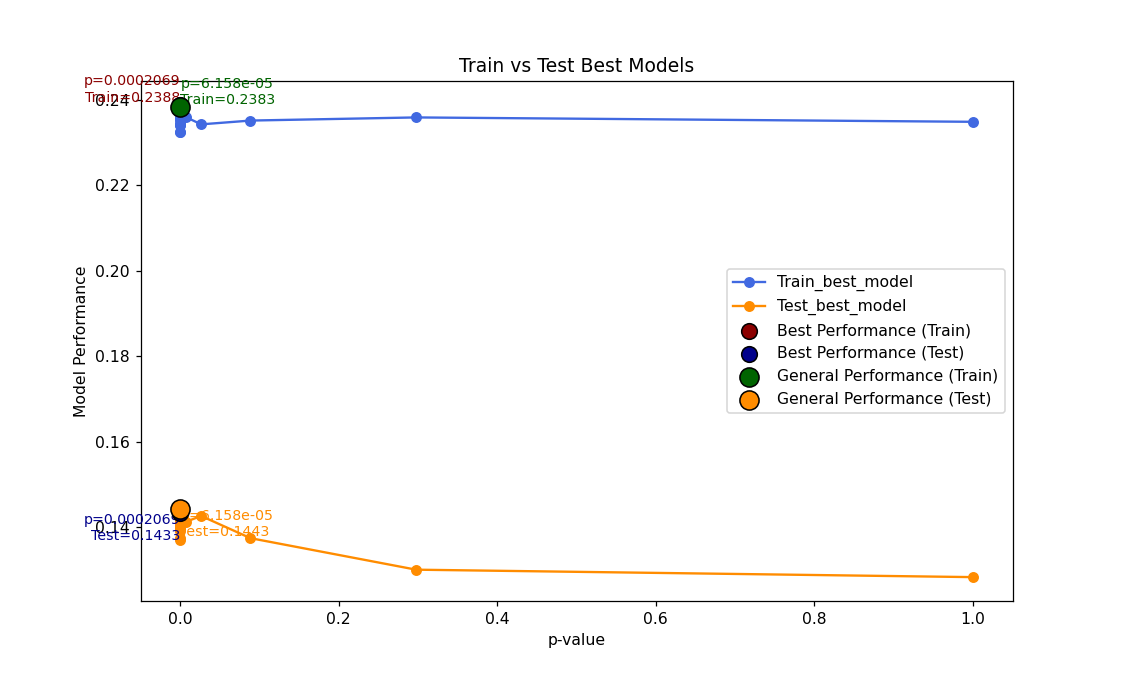

2. Reporting Generalized Performance:

|                  |            11 |
|:-----------------|--------------:|
| clump_p1         |   1           |
| clump_r2         |   0.1         |
| clump_kb         | 200           |
| p_window_size    | 200           |
| p_slide_size     |  50           |
| p_LD_threshold   |   0.25        |
| pvalue           |   6.15848e-05 |
| numberofpca      |   6           |
| tempalpha        |   0.1         |
| l1weight         |   0.1         |
| Train_pure_prs   |   3.81345e-06 |
| Train_null_model |   0.22945     |
| Train_best_model |   0.238254    |
| Test_pure_prs    |   9.81723e-06 |
| Test_null_model  |   0.12828     |
| Test_best_model  |   0.144273    |
| Difference       |   0.0939814   |
| Sum              |   0.382527    |
3. Reporting the correlation of hyperparameters and the performance of 'Train_null_model', 'Train_pure_prs', 'Train_best_model', 'Test_pure_prs', 'Test_null_model', and 'Test_best_model':

3. For string hyperparameters, w

<IPython.core.display.Javascript object>


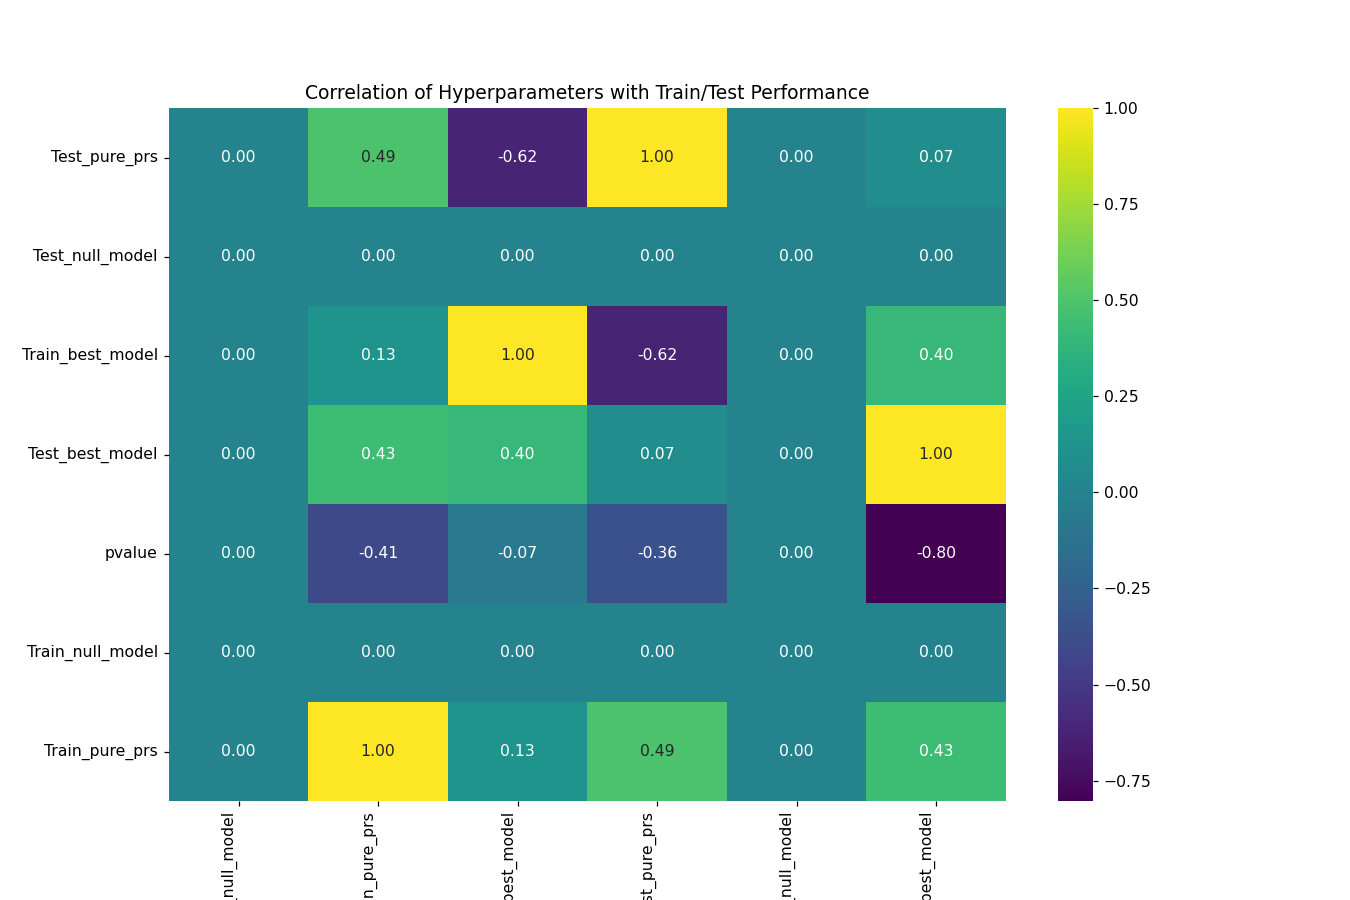

<IPython.core.display.Javascript object>


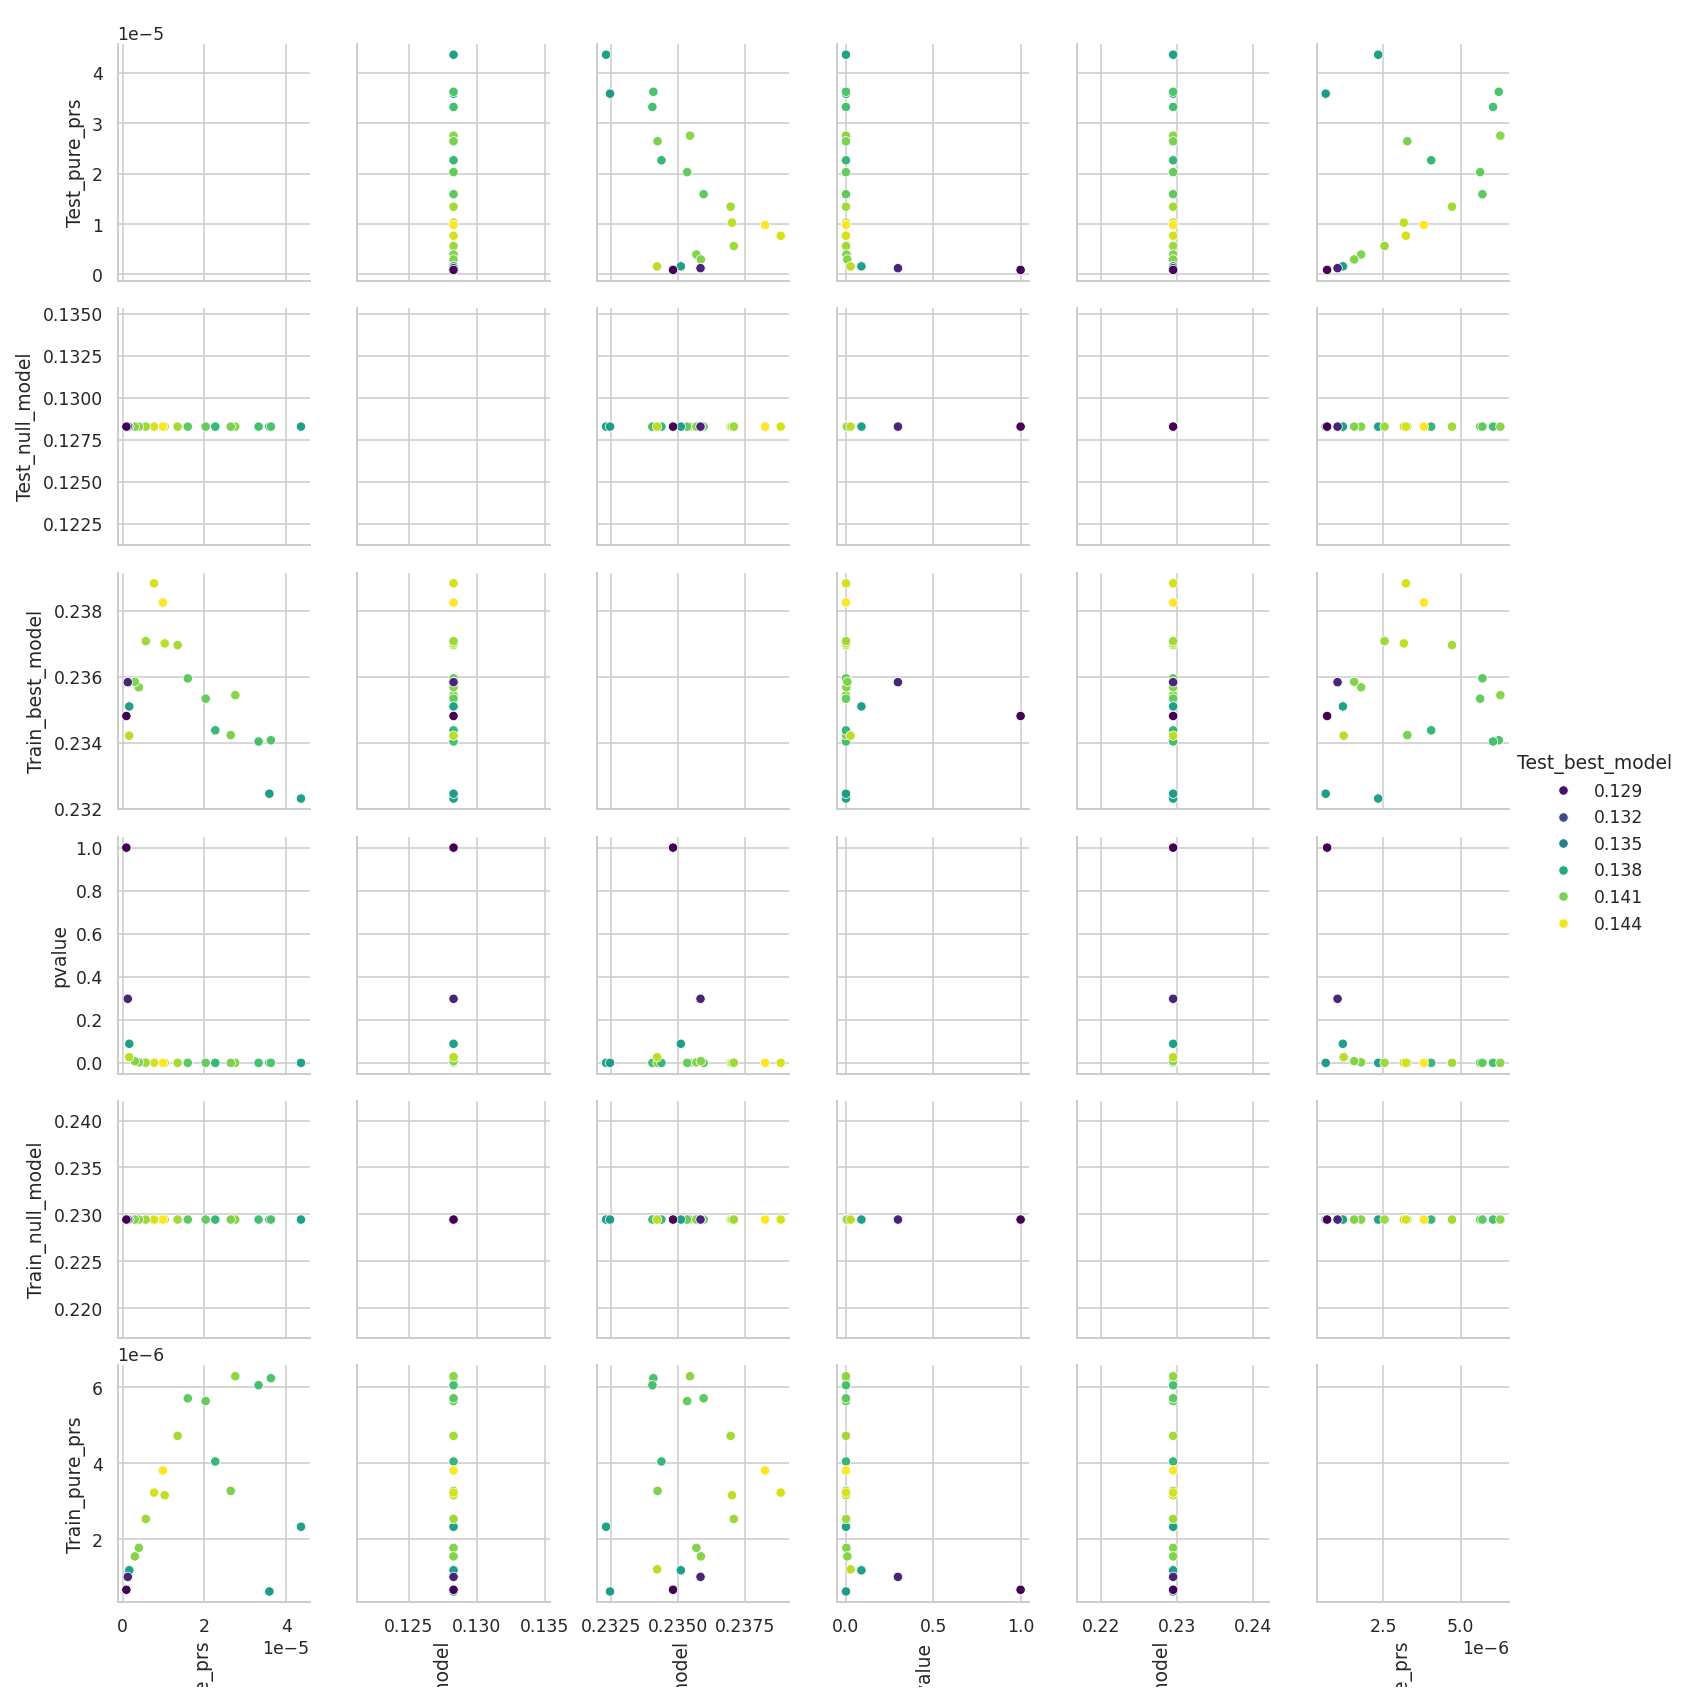

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

df = divided_result.sort_values(by='Train_best_model', ascending=False)
print("1. Reporting Based on Best Training Performance:\n")
print(df.iloc[0].to_markdown())


 
df = divided_result.copy()

# Plot Train and Test best models against p-values
plt.figure(figsize=(10, 6))
plt.plot(df['pvalue'], df['Train_best_model'], label='Train_best_model', marker='o', color='royalblue')
plt.plot(df['pvalue'], df['Test_best_model'], label='Test_best_model', marker='o', color='darkorange')

# Highlight the p-value where both train and test are high
best_index = df[['Train_best_model']].sum(axis=1).idxmax()
best_pvalue = df.loc[best_index, 'pvalue']
best_train = df.loc[best_index, 'Train_best_model']
best_test = df.loc[best_index, 'Test_best_model']

# Use dark colors for the circles
plt.scatter(best_pvalue, best_train, color='darkred', s=100, label=f'Best Performance (Train)', edgecolor='black', zorder=5)
plt.scatter(best_pvalue, best_test, color='darkblue', s=100, label=f'Best Performance (Test)', edgecolor='black', zorder=5)

# Annotate the best performance with p-value, train, and test values
plt.text(best_pvalue, best_train, f'p={best_pvalue:.4g}\nTrain={best_train:.4g}', ha='right', va='bottom', fontsize=9, color='darkred')
plt.text(best_pvalue, best_test, f'p={best_pvalue:.4g}\nTest={best_test:.4g}', ha='right', va='top', fontsize=9, color='darkblue')

# Calculate Difference and Sum
df['Difference'] = abs(df['Train_best_model'] - df['Test_best_model'])
df['Sum'] = df['Train_best_model'] + df['Test_best_model']

# Sort the DataFrame
sorted_df = df.sort_values(by=['Sum', 'Difference'], ascending=[False, True])
#sorted_df = df.sort_values(by=[ 'Difference','Sum'], ascending=[  True,False])

# Highlight the general performance
general_index = sorted_df.index[0]
general_pvalue = sorted_df.loc[general_index, 'pvalue']
general_train = sorted_df.loc[general_index, 'Train_best_model']
general_test = sorted_df.loc[general_index, 'Test_best_model']

plt.scatter(general_pvalue, general_train, color='darkgreen', s=150, label='General Performance (Train)', edgecolor='black', zorder=6)
plt.scatter(general_pvalue, general_test, color='darkorange', s=150, label='General Performance (Test)', edgecolor='black', zorder=6)

# Annotate the general performance with p-value, train, and test values
plt.text(general_pvalue, general_train, f'p={general_pvalue:.4g}\nTrain={general_train:.4g}', ha='left', va='bottom', fontsize=9, color='darkgreen')
plt.text(general_pvalue, general_test, f'p={general_pvalue:.4g}\nTest={general_test:.4g}', ha='left', va='top', fontsize=9, color='darkorange')

# Add labels and legend
plt.xlabel('p-value')
plt.ylabel('Model Performance')
plt.title('Train vs Test Best Models')
plt.legend()
plt.show()
 




print("2. Reporting Generalized Performance:\n")
df = divided_result.copy()
df['Difference'] = abs(df['Train_best_model'] - df['Test_best_model'])
df['Sum'] = df['Train_best_model'] + df['Test_best_model']
sorted_df = df.sort_values(by=['Sum', 'Difference'], ascending=[False, True])
print(sorted_df.iloc[0].to_markdown())


print("3. Reporting the correlation of hyperparameters and the performance of 'Train_null_model', 'Train_pure_prs', 'Train_best_model', 'Test_pure_prs', 'Test_null_model', and 'Test_best_model':\n")

print("3. For string hyperparameters, we used one-hot encoding to find the correlation between string hyperparameters and 'Train_null_model', 'Train_pure_prs', 'Train_best_model', 'Test_pure_prs', 'Test_null_model', and 'Test_best_model'.")

print("3. We performed this analysis for those hyperparameters that have more than one unique value.")

correlation_columns = [
 'Train_null_model', 'Train_pure_prs', 'Train_best_model',
 'Test_pure_prs', 'Test_null_model', 'Test_best_model'
]

hyperparams = [col for col in divided_result.columns if len(divided_result[col].unique()) > 1]
hyperparams = list(set(hyperparams+correlation_columns))
 
# Separate numeric and string columns
numeric_hyperparams = [col for col in hyperparams if pd.api.types.is_numeric_dtype(divided_result[col])]
string_hyperparams = [col for col in hyperparams if pd.api.types.is_string_dtype(divided_result[col])]


# Encode string columns using one-hot encoding
divided_result_encoded = pd.get_dummies(divided_result, columns=string_hyperparams)

# Combine numeric hyperparams with the new one-hot encoded columns
encoded_columns = [col for col in divided_result_encoded.columns if col.startswith(tuple(string_hyperparams))]
hyperparams = numeric_hyperparams + encoded_columns
 

# Calculate correlations
correlations = divided_result_encoded[hyperparams].corr()
 
# Display correlation of hyperparameters with train/test performance columns
hyperparam_correlations = correlations.loc[hyperparams, correlation_columns]
 
hyperparam_correlations = hyperparam_correlations.fillna(0)

# Plotting the correlation heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(hyperparam_correlations, annot=True, cmap='viridis', fmt='.2f', cbar=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

# Rotate y-axis labels to horizontal
#ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va='center')

plt.title('Correlation of Hyperparameters with Train/Test Performance')
plt.show() 

sns.set_theme(style="whitegrid")  # Choose your preferred style
pairplot = sns.pairplot(divided_result_encoded[hyperparams],hue = 'Test_best_model', palette='viridis')

# Adjust the figure size
pairplot.fig.set_size_inches(15, 15)  # You can adjust the size as needed

for ax in pairplot.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation=90, ha='right')  # X-axis labels vertical
    #ax.set_ylabel(ax.get_ylabel(), rotation=0, va='bottom')  # Y-axis labels horizontal

# Show the plot
plt.show()


